**Bayesian Data Analysis 2019 - Data Analysis Project Report**

This is a template with format instructions for Assignments in the Bayesian Data Analysis course at Aalto University. R markdown is a convenient way of writing exercise reports by combining text and R code using markdown syntax. To create your assignment, remove the formatting instructions and use this file as a template.

More information on how to use markdown, see [this](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and more information on R markdown can be found [here](https://www.rstudio.com/wp-content/uploads/2015/02/rmarkdown-cheatsheet.pdf).

Also, _R Markdown: The Definite Guide_, an extensive book on R Markdown can be found [here](https://bookdown.org/yihui/rmarkdown/).

**Note** The report should be anonymous and submitted to [peergrade.io](peergrade.io) as `assignmentX.pdf`. If you have problem with creating a PDF file directly from R markdown, start by creating an HTML file and the just print the HTML to a PDF. 


# Loaded packages

Below are examples of how to load packages that are used in the assignment

In [24]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [25]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


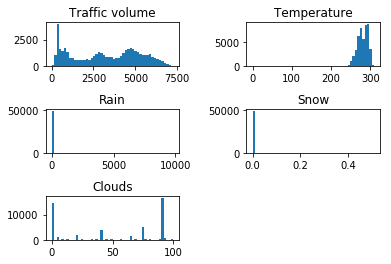

In [44]:
# First look at the data

plt.subplot(3,2,1)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.hist(df['traffic_volume'], bins=50)
plt.title("Traffic volume")
plt.subplot(3,2,2)
plt.hist(df['temp'], bins=50)
plt.title("Temperature")
plt.subplot(3,2,3)
plt.hist(df['rain_1h'], bins=50)
plt.title("Rain")
plt.subplot(3,2,4)
plt.hist(df['snow_1h'], bins=50)
plt.title("Snow")
plt.subplot(3,2,5)
plt.hist(df['clouds_all'], bins=50)
plt.title("Clouds")
plt.show()

# Including source code

In general, all code needed to produce the essential parts needs to be included, so that it is possible to see, for peer reviewers, where errors may have happened

You can always look at the open rubrics to see how and what is asked for in each exercise.

Try to avoid printing an excessive amount of code and think about what is essential for showing how did you get the result.

Write clear code. The code is also part of your report and clarity of the report affects your score. If the code is not self-explanatory, add comments. In a notebook, you can interleave explaining text and code.

If in doubt additional source code can be included in an appendix. 

# Format instructions

All exercises in the assignment should start with header 1 fully specifying that it is exercise X, as:

# Exercise 1)
## a)

Subtasks in each assignments should be numbered and use header 2 (two ##). 

We can easily add R code as chunks in the following way:

In [1]:
1+1

2

# Plots

Include plots, where we can specify the width and height of the figure.


# Equations

Equations should be correctly formated using LaTeX or being included as images if, for example, Microsoft Equations is used. 

In Markdown, equations can easily be formulated using LaTeX in line as $f(k) = {n \choose k} p^{k} (1-p)^{n-k}$ or use the math environment as follows:

$$\begin{array}{ccc}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}
\end{array}$$

If you are new to LaTeX equations, you could use the [latext4technics](https://www.latex4technics.com/) equation editor to create LaTeX equations to include in the report.

More information on using LaTeX in R markdown can be found in 2.5.3 in [R Markdown: The Definite Guide](https://bookdown.org/yihui/rmarkdown/).

A short introduction to equations in LaTeX can be found [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).

# Language

The language used in the course is English. Hence the report needs to be written in English.

# Jupyter Notebook and other report formats
You are allowed to use any format to produce your report, such as Jupyter Notebook, as long as you obide by the instructions in this 

template.